# 1- Train the models

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data, get_dir
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th
import plot as plot
from matplotlib.colors import ListedColormap
from utils import normalize_phase_data




#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [2]:
n_model = 40 # number of simulated networks
network_siz = 128
folder_name = f'Sim_fixed_{network_siz}'

# General things

You can specify a saving directory, basically the directory in which the figure can be saved.
The base directory is **hard-coded** in the current version of the code.


In [3]:

root_dir = '/Volumes/T9/MotorNet'
root_dir = os.path.join(os.path.expanduser('~'),'Documents/Data/MotorNet')

base_dir = root_dir
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox/Projects/papers/MotorSavings/paper/figures_raw')
# save_fig = os.path.join(os.path.expanduser('~'),'Documents/Figs/MotorNet')


# #1: Estimating TDR and uniform shift

In [5]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 59 # 25 # time point just after the reach onset


ignore = return_ignore(folder_name,n_model,ff_coef=8) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

data_tdr = []
US = []

for mn in range(n_model):
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        US.append(None)
        continue

    # 1. Load data
    U = get_data(folder_name,model_name,n_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)

    # 2 projection onto TDR
    data_p = project_onto_map(data,tdr,remove_mean=True)
    data_tdr.append(data_p)

    # 3 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us_orth, us_orth_norm = orth_wrt_map(us,tdr)
    US.append(us_orth)

    proj_onto_us = project_onto_map(data,us_orth,remove_mean=False,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()

    d = {
    'mn': [mn] * 4,
    'phase': ['NF1','FF1','NF2','FF2'],  
    'us': u_mean.tolist()
    }

    T = pd.concat([T, pd.DataFrame(d)], ignore_index=True)

[2025-12-20 05:13:48,289] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2025-12-20 05:13:48,289] torch._dynamo.convert_frame: [WARNING]    function: '_integrate' (/Users/mahdiyarshahbazi/Documents/GitHub/MotorNet/motornet/muscle.py:570)
[2025-12-20 05:13:48,289] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2025-12-20 05:13:48,289] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2025-12-20 05:13:48,289] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
[2025-12-20 05:13:48,291] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2025-12-20 05:13:48,291] torch._dynamo.convert_frame: [WARNING]    function: 'clip_activation' (/Users/mahdiyarshahbazi/Documents/GitHub/MotorNet/motornet/muscle.py:62)
[2025-12-20 05:13:48,291] torch._dynamo.conver

# Plot projection on TDR

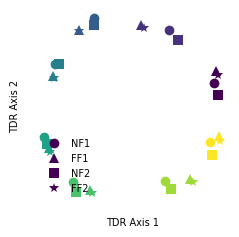

In [6]:
fig, ax = plot.plot_tdr(data_tdr[0],figsize=(2.5,2.5))
#fig.savefig(os.path.join(save_fig,'tdr.pdf'),dpi=300,bbox_inches='tight')

# Plot projection on uniform shift

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


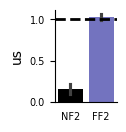

In [7]:
# Apply normalization
normalized_T,scale = normalize_phase_data(T)
normalized_T = normalized_T[normalized_T['phase'].isin(['NF2', 'FF2'])]

fig, ax = plot.my_barplot(normalized_T,x='phase',y='us',hue='phase',figsize=(0.8,1.2),width=0.8)
ax.axhline(1, color='black',linestyle='--',linewidth=2)
# fig.savefig(os.path.join(save_fig,'proj_on_us_0.pdf'),dpi=300,bbox_inches='tight')

In [7]:
from scipy.stats import ttest_rel, ttest_1samp

a = normalized_T[normalized_T['phase']=='NF2']['us'].values
t_stat, p_value = ttest_1samp(a,0)
print(f't-statistic: {t_stat}, p-value: {p_value}')

t-statistic: 5.438208932909189, p-value: 3.117801098904503e-06


# #2: Perturbation along and opposite uniform shift

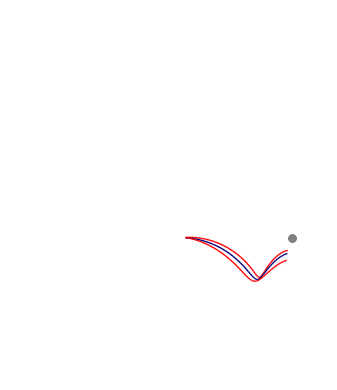

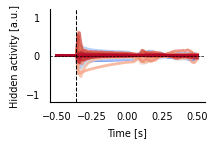

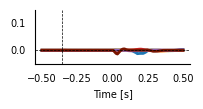

In [8]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 59 # 25 # time point just after the reach onset
i = 0
ignore = return_ignore(folder_name,n_model)

models = [3]

for mn in models:
    model_name = 'model{:02d}'.format(mn)
    if mn in ignore:
        continue
    
    us_orth = US[mn]
    
    # perturb hidden
    data = []
    for mag in [2,0,-2]: # positive and negative perturbation
        d_hidden = th.from_numpy(mag*us_orth.T) # 0.6

        # now lets perturb or not and calculate the saving in behavior
        data_, = get_data(folder_name,model_name,{'NF2':[0]},[8],n_hidden=network_siz,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,catch_trial_perc=0) 
        data.append(data_)

    #1: plot trajectories
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    plot.plot_simulations(ax,xy=data[0]['xy'][i][None],target_xy=data[0]['tg'][i][None],cmap=ListedColormap(['red'],N=1),s=25,color_dot=np.array([0.5,0.5,0.5,1]))
    plot.plot_simulations(ax,xy=data[1]['xy'][i][None],target_xy=data[1]['tg'][i][None],cmap=ListedColormap(['navy'],N=1),s=25,color_dot=np.array([0.5,0.5,0.5,1]))
    plot.plot_simulations(ax,xy=data[2]['xy'][i][None],target_xy=data[2]['tg'][i][None],cmap=ListedColormap(['red'],N=1),s=25,color_dot=np.array([0.5,0.5,0.5,1]))

    #2: hidden
    hidden_0 = np.array(data[1]['all_hidden'][i,:,:])
    hidden_2 = np.array(data[0]['all_hidden'][i,:,:])
    x = np.linspace(0, np.shape(hidden_0)[0]*0.01, np.shape(hidden_0)[0])-0.5
    
    color_hidden1 = plt.cm.coolwarm(np.linspace(0, 1, hidden_0.shape[1]))
    #np.random.shuffle(color_hidden1)

    fg, ax = plot.my_plot(x,hidden_2-hidden_0,color_hidden1,(2,1.2),labels=None,ylim=[-1.2,1.2],plot0=True,ylabel='Hidden activity [a.u.]',alpha=0.75)
    ax.axvline(-0.36,color='k',linestyle='--',linewidth=0.75)
    #fg.savefig(os.path.join(save_fig,'delta_hidden.pdf'),dpi=300,bbox_inches='tight')



    #3: motor output
    output_0 = np.array(data[1]['all_action'][i,:,:])
    output_2 = np.array(data[0]['all_action'][i,:,:])

    color_output = np.ones((6,4))
    color_output[0,:3] = (31/255,119/255,180/255)
    color_output[1,:3] = (255/255,127/255,14/255)
    color_output[2,:3] = (44/255,160/255,44/255)
    color_output[3,:3] = (213/255,39/255,40/255)
    color_output[4,:3] = (148/255,103/255,189/255)
    color_output[5,:3] = (122/255,21/255,0/255)


    fg, ax = plot.my_plot(x,output_0-output_2,color_output,(2.,0.7),labels=None,ylim=[-0.05,0.15],plot0=True,ylabel='',linestyle=None)
    ax.axvline(-0.36, color='k',linestyle='--',linewidth=0.5)
    #fg.savefig(os.path.join(save_fig,'delta.pdf'),dpi=300,bbox_inches='tight')


In [4]:
N_idx_tdr = 16  # timepoint for building TDR (fixed)
F_idx_tdr = 59  # timepoint for force in TDR (fixed)
N_idx_range = range(0, 100)  # all timepoints for projection
ortho_tdr = True  # Set to True to orthogonalize w.r.t. TDR, False to skip

ignore = return_ignore(folder_name, n_model, ff_coef=8)

proj_us_all_time = []

for mn in range(n_model):
    model_name = f"model{mn:02d}"
    if mn in ignore:
        proj_us_all_time.append(None)
        continue
    
    U = get_data(folder_name, model_name, n_hidden=network_siz)
    
    # Build TDR once at fixed timepoint (only if ortho_tdr is True)
    if ortho_tdr:
        data_tdr = []
        for i in range(len(U)):
            data_tdr.append(np.array(U[i]['all_hidden'])[:, N_idx_tdr, :])
        
        combined_N = np.vstack(data_tdr)
        mean_N = np.mean(combined_N, axis=0)
        X = np.array(U[0]['endpoint_force'])[:, F_idx_tdr, :]
        N = data_tdr[0] - mean_N
        tdr = build_tdr(X, N)
    
    proj_us_model = []
    
    for N_idx in N_idx_range:
        data = []
        for i in range(len(U)):
            data.append(np.array(U[i]['all_hidden'])[:, N_idx, :])
        
        # Uniform shift at this timepoint
        us = np.mean(data[1] - data[0], axis=0).reshape(-1, 1)
        
        if ortho_tdr:
            us_orth, us_orth_norm = orth_wrt_map(us, tdr)
        else:
            us_orth = us / np.linalg.norm(us)  # Just normalize, don't orthogonalize
        
        # Project all conditions onto uniform shift
        proj_onto_us = project_onto_map(data, us_orth, remove_mean=False, mean_all=True)
        u_mean = np.mean(np.array(proj_onto_us), axis=1).ravel()
        
        proj_us_model.append(u_mean)
    
    proj_us_all_time.append(np.array(proj_us_model))


[2025-12-20 16:31:17,327] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2025-12-20 16:31:17,327] torch._dynamo.convert_frame: [WARNING]    function: '_integrate' (/Users/mahdiyarshahbazi/Documents/GitHub/MotorNet/motornet/muscle.py:570)
[2025-12-20 16:31:17,327] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2025-12-20 16:31:17,327] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2025-12-20 16:31:17,327] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.
[2025-12-20 16:31:17,329] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2025-12-20 16:31:17,329] torch._dynamo.convert_frame: [WARNING]    function: 'clip_activation' (/Users/mahdiyarshahbazi/Documents/GitHub/MotorNet/motornet/muscle.py:62)
[2025-12-20 16:31:17,329] torch._dynamo.conver

In [5]:
data[1].shape

(8, 128)

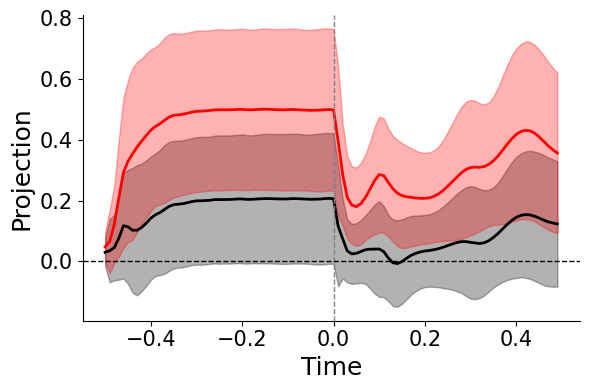

In [6]:
fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20

normalize = False  # Set to False to skip normalization
normalize_each_time = True  # Set to True to normalize at each timepoint separately

proj_us_plot = []
scales = []

for mn, proj_data in enumerate(proj_us_all_time):
    if proj_data is None:
        proj_us_plot.append(None)
        scales.append(None)
        continue
    
    if normalize:
        if normalize_each_time:
            # Normalize at each timepoint separately
            proj_plot = np.zeros_like(proj_data)
            scales_time = []
            for t in range(proj_data.shape[0]):
                NF1_t = proj_data[t, 0]
                FF1_t = proj_data[t, 1]
                scaling_factor_t = FF1_t - NF1_t
                scales_time.append(scaling_factor_t)
                proj_plot[t] = (proj_data[t] - NF1_t) / scaling_factor_t if scaling_factor_t != 0 else 0
            scales.append(scales_time)
            proj_us_plot.append(proj_plot)
        else:
            # Normalize using reference timepoint
            NF1_ref = proj_data[16, 0]
            FF1_ref = proj_data[16, 1]
            scaling_factor = FF1_ref - NF1_ref
            scales.append(scaling_factor)
            proj_plot = (proj_data - NF1_ref) / scaling_factor
            proj_us_plot.append(proj_plot)
    else:
        proj_us_plot.append(proj_data)
        scales.append(1.0)

# Convert to array
proj_us_plot_array = np.array([p for p in proj_us_plot if p is not None])

# Plot NF2 and FF2
nf2_plot = proj_us_plot_array[:, :, 2]
ff2_plot = proj_us_plot_array[:, :, 3]

fig, ax = plt.subplots(figsize=(6, 4))
time = (np.arange(100)-50)*0.01

ax.plot(time, np.mean(nf2_plot, axis=0), color='black', linewidth=2, label='NF2')
ax.fill_between(time, 
                np.mean(nf2_plot, axis=0) - np.std(nf2_plot, axis=0),
                np.mean(nf2_plot, axis=0) + np.std(nf2_plot, axis=0),
                color='black', alpha=0.3)

ax.plot(time, np.mean(ff2_plot, axis=0), color='red', linewidth=2, label='FF2')
ax.fill_between(time, 
                np.mean(ff2_plot, axis=0) - np.std(ff2_plot, axis=0),
                np.mean(ff2_plot, axis=0) + np.std(ff2_plot, axis=0),
                color='red', alpha=0.3)

ax.axvline(0, color='gray', linestyle='--', linewidth=1, label='Go cue')
if normalize and not normalize_each_time:
    ax.axvline(16, color='blue', linestyle='--', linewidth=1, label='Norm point')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time', fontsize=fontsize_label)
ax.set_ylabel('Normalized projection' if normalize else 'Projection', fontsize=fontsize_label)
ax.tick_params(labelsize=fontsize_tick)
# ax.legend(fontsize=fontsize_legend)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(save_fig,'projection_trial.pdf'),dpi=300,bbox_inches='tight')
